<a href="https://colab.research.google.com/github/apollosoldier/todo/blob/master/Project_Estimation_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Creation data

Acquisition de nos données.
Cette base de donnée a été acquit grace à un script python, qui fait des request gràce a l'api Kraken pour ensuite le parser en plusieurs fichier et ce sont ces fichiers que nous allons analysé.

In [ ]:
import pandas as pd
import requests
import json


def fetch_OHLC_data(symbol, timeframe):
    pair_split = symbol.split('/')
    symbol = pair_split[0] + pair_split[1]
    url = f'https://api.kraken.com/0/public/OHLC?pair={symbol}&interval={timeframe}'
    response = requests.get(url)
    if response.status_code == 200:
        j = json.loads(response.text)
        result = j['result']
        keys = []
        for item in result:
            keys.append(item)
        if keys[0] != 'last':
            data = pd.DataFrame(result[keys[0]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])
        else:
            data = pd.DataFrame(result[keys[1]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])

        data['date'] = pd.to_datetime(data['unix'], unit='s')
        data['volume_from'] = data['volume'].astype(float) * data['close'].astype(float)

        if data is None:
            print("Did not return any data from Kraken for this symbol")
        else:
            if timeframe == '1':
                tf = 'minute'
            elif timeframe == '60':
                tf = 'hour'
            elif timeframe == '1440':
                tf = 'day'
            else:
                tf = ''
            data.to_csv(f'Kraken_{symbol}_{tf}.csv', index=False)
            return data
    else:
        print("Did not receieve OK response from Kraken API")

def fetch_SPREAD_data(symbol):
    pair_split = symbol.split('/')
    symbol = pair_split[0] + pair_split[1]
    url = f'https://api.kraken.com/0/public/Spread?pair={symbol}'
    response = requests.get(url)
    if response.status_code == 200:
        j = json.loads(response.text)
        result = j['result']
        keys = []
        for item in result:
            keys.append(item)
        if keys[0] != 'last':
            data = pd.DataFrame(result[keys[0]], columns=['unix', 'bid', 'ask'])
        else:
            data = pd.DataFrame(result[keys[1]], columns=['unix', 'bid', 'ask'])

        data['date'] = pd.to_datetime(data['unix'], unit='s')
        data['spread'] = data['ask'].astype(float) - data['bid'].astype(float)

        if data is None:
            print("Did not return any data from Kraken for this symbol")
        else:
            data.to_csv(f'Kraken_{symbol}_spreads.csv', index=False)
            return data
    else:
        print("Did not receieve OK response from Kraken API")

def fetch_PRINTS_data(symbol):
    pair_split = symbol.split('/')
    symbol = pair_split[0] + pair_split[1]
    url = f'https://api.kraken.com/0/public/Trades?pair={symbol}'
    response = requests.get(url)
    if response.status_code == 200:
        j = json.loads(response.text)

        result = j['result']
        keys = []
        for item in result:
            keys.append(item)
        if keys[0] != 'last':
            data = pd.DataFrame(result[keys[0]], columns=['price', 'volume', 'time', 'buysell', 'ordtype', 'misc'])
        else:
            data = pd.DataFrame(result[keys[1]], columns=['price', 'volume', 'time', 'buysell', 'ordtype', 'misc'])

        data['date'] = pd.to_datetime(data['time'], unit='s')
        data['buysell'] = data['buysell'].apply(lambda x: "buy" if x == 'b' else "sell")
        data['ordtype'] = data['ordtype'].apply(lambda x: "limit" if x == 'l' else "market")
        data['dollaramount'] = data['price'].astype(float) * data['volume'].astype(float)
        data.drop(columns=['misc'], inplace=True)  #drop misc column that is typically blank

        if data is None:
            print("Did not return any data from Kraken for this symbol")
        else:
            data.to_csv(f'Kraken_{symbol}_tradeprints.csv', index=False)
            return data
    else:
        print("Did not receieve OK response from Kraken API")


if __name__ == "__main__":
    pair = "BTC/EUR"
    timeframe = '1440'
    df1 = fetch_OHLC_data(symbol=pair,timeframe= '1440')
    # fetch_OHLC_data(symbol=pair, timeframe='60')  # fetches hourly data
    # fetch_OHLC_data(symbol=pair, timeframe='1440')  # fetches daily data
    df2 = fetch_SPREAD_data(symbol=pair) # gets bid/ask spread data
    df3 = fetch_PRINTS_data(symbol=pair) # gets historical trade print data
    frames = [df1, df2, df3]
    data = pd.concat(frames, axis=1, join='inner')
    data.to_csv('Kraken_global_data.csv', index=False)

Après avoir obtenu nos données, nous allons mettre en place un environnement de developpement R.

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Nous allons faire appel a des packages que dont nous aurons besoin et installer aussi celle dont on aura besoin dans la suite du tp.

In [ ]:
%%R
library(dplyr)
library(ggplot2)

#Installation des packages

In [ ]:
%%R
mypack <- function(package){
  new.package <- package[!(package %in% installed.packages()[, "Package"])]
  if (length(new.package)) 
    install.packages(new.package, dependencies = FALSE)
  sapply(package, require, character.only = TRUE)
}

R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘xts’, ‘TTR’, ‘later’, ‘quadprog’, ‘quantmod’, ‘png’, ‘jpeg’, ‘checkmate’, ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’, ‘Formula’, ‘latticeExtra’, ‘gridExtra’, ‘htmlTable’, ‘viridis’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/xts_0.12.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 517875 bytes (505 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

In [ ]:
%%R
package <- c("plotly","forecast","FactoMineR", "tidyverse", "Hmisc", "prophet")
mypack(package)

#Data loading

Après avoir installer les packages necessaire, nous allons faire appel à nos fichier csv pour ensuite les annalysés.

In [ ]:
%%R
Kraken_BTCEUR_day <- read.csv("Kraken_BTCEUR_day.csv")
Kraken_global <- read.csv("Kraken_global_data.csv")
cat("Les features de nos jeux de données Kraken_BTCEUR_day: ", colnames(Kraken_BTCEUR_day))
cat("\nLes features de nos jeux de données Kraken_global_data: ", colnames(Kraken_global))
btc <- data.frame(Kraken_BTCEUR_day)

Les features de nos jeux de données Kraken_BTCEUR_day:  unix open high low close vwap volume tradecount date volume_from
Les features de nos jeux de données Kraken_global_data:  unix open high low close vwap volume tradecount date volume_from unix.1 bid ask date.1 spread price volume.1 time buysell ordtype date.2 dollaramount

In [ ]:
%%R
print(head(Kraken_global, 1))
unix <- data.frame(Kraken_global$unix)
open <- Kraken_global$open
high <- Kraken_global$high
low <- Kraken_global$low
close <- Kraken_global$close
vwap <- data.frame(Kraken_global$vwap)
volume <- data.frame(Kraken_global$volume)
tradecount <- data.frame(Kraken_global$tradecount)
date <- data.frame(Kraken_global$date)
volume_from <- data.frame(Kraken_global$volume_from)
dollaramount <- data.frame(Kraken_global$dollaramount)


cat(typeof(Kraken_global$unix), ' Unix\n')
cat(typeof(Kraken_global$open), ' Open\n')
cat(typeof(Kraken_global$high),' High\n')
cat(typeof(Kraken_global$low),' Low\n')

cat(typeof(Kraken_global$close),' Close\n')

cat(typeof(Kraken_global$vwap),' Vwap\n')

cat(typeof(Kraken_global$volume),' Volume\n')
cat(typeof(Kraken_global$tradecount),' Trade Count\n')
cat(typeof(Kraken_global$date),' Date\n')
cat(typeof(Kraken_global$volume_from),' Volume from\n')
cat(typeof(Kraken_global$bid),' Bid\n')
cat(typeof(Kraken_global$ask),' Ask\n')
cat(typeof(Kraken_global$spread),' Spread\n')
cat(typeof(Kraken_global$price),' Price\n')
cat(typeof(Kraken_global$time),' Time\n')
cat(typeof(Kraken_global$buysell ),' BuySell\n')
cat(typeof(Kraken_global$ordtype),' Ordtype\n')
summary(Kraken_global)

        unix   open   high    low  close   vwap   volume tradecount       date
1 1575417600 6595.1 7047.9 6411.1 6493.2 6634.5 6633.067      25656 2019-12-04
  volume_from     unix.1   bid     ask              date.1 spread   price
1    43069831 1637614780 49807 49811.7 2021-11-22 20:59:40    4.7 50031.4
    volume.1       time buysell ordtype                        date.2
1 0.00491182 1637613712     buy   limit 2021-11-22 20:41:51.807600021
  dollaramount
1     245.7452
integer  Unix
double  Open
double  High
double  Low
double  Close
double  Vwap
double  Volume
integer  Trade Count
character  Date
double  Volume from
double  Bid
double  Ask
double  Spread
double  Price
double  Time
character  BuySell
character  Ordtype
      unix                open           high           low      
 Min.   :1.575e+09   Min.   :4393   Min.   :4839   Min.   :3550  
 1st Qu.:1.580e+09   1st Qu.:6507   1st Qu.:6641   1st Qu.:6422  
 Median :1.584e+09   Median :7810   Median :7940   Median :7592  
 Mean

Après cette petite observation, on peut conclure que nos features sont un peu varié, on à des variables quantitative et qualitalive.

# **Quantitative : Discrète en Continue**


Exemple : **Unix** est quantitative et discrète 
          **Open** est quantitative et continue

#**Qualitative : Nominal et Ordinal**

On voit ques nos features sont de type caractère donc dans le futur, on sera obligé de transformé, certain en numerique.

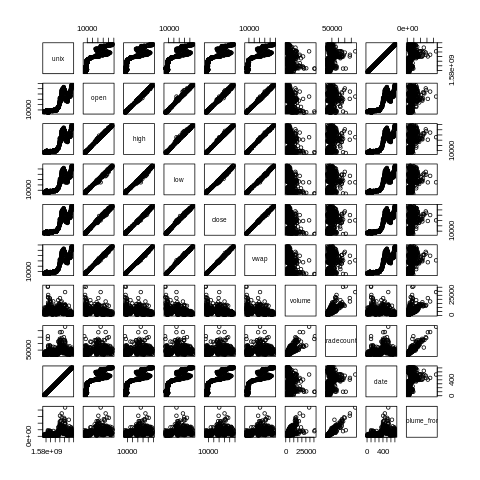

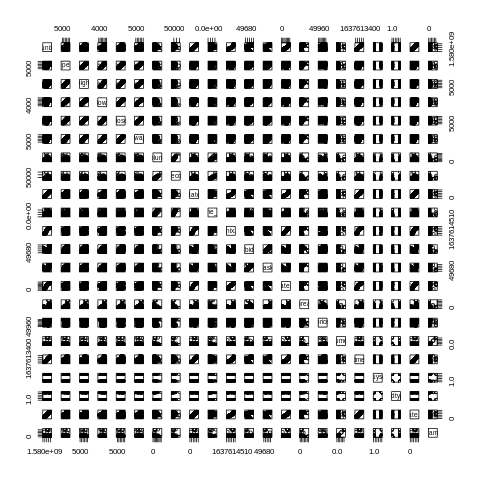

In [ ]:
%%R
kraken <- data.frame(Kraken_BTCEUR_day)
global_data = data.frame(Kraken_global)
plot (kraken)
plot(global_data)
#summary(kraken)
#summary(global_data)

In [ ]:
%%R
global_data$price[!is.na(global_data$price)]
global_data$unix[!is.na(global_data$unix)]

summary(global_data)

      unix                open            high            low      
 Min.   :1.575e+09   Min.   : 4393   Min.   : 4839   Min.   :3550  
 1st Qu.:1.581e+09   1st Qu.: 6595   1st Qu.: 6753   1st Qu.:6473  
 Median :1.586e+09   Median : 8059   Median : 8183   Median :7925  
 Mean   :1.586e+09   Mean   : 7691   Mean   : 7875   Mean   :7503  
 3rd Qu.:1.591e+09   3rd Qu.: 8499   3rd Qu.: 8666   3rd Qu.:8312  
 Max.   :1.597e+09   Max.   :10038   Max.   :10283   Max.   :9808  
     close            vwap          volume        tradecount    
 Min.   : 4393   Min.   :4377   Min.   : 1051   Min.   :  9875  
 1st Qu.: 6604   1st Qu.:6619   1st Qu.: 3415   1st Qu.: 19682  
 Median : 8060   Median :8068   Median : 5113   Median : 25998  
 Mean   : 7705   Mean   :7696   Mean   : 6237   Mean   : 29910  
 3rd Qu.: 8510   3rd Qu.:8476   3rd Qu.: 7116   3rd Qu.: 35181  
 Max.   :10038   Max.   :9941   Max.   :36178   Max.   :157424  
     date            volume_from            unix.1               bid 

## **Moyennes, écart-types, médiane**

In [ ]:
%%R
btc2 <- data.frame(global_data)
x <- "Moyenne: "
y <- "Mediane: "
z <- "Variance: "
t <- "Ecart type: "
cat ("[Open]  --> ",x,mean(btc$open)," ; ", y, median(btc$open), "; ", z,var(btc$open) ,"; ",t, sd(btc$open),  "\n")
cat ("[Close] --> ",x,mean(btc$close)," ; ", y, median(btc$close), " ; ", z,var(btc$close) ,"; ",t, sd(btc$close),  "\n" )
cat ("[High]  --> ", x,mean(btc$high)," ; ", y, median(btc$high), " ; ", z,var(btc$high) ,"; ",t, sd(btc$high), "\n" )
cat ("[Low]   --> ", x,mean(btc$low)," ; ", y, median(btc$low), " ; ", z,var(btc$low) ,"; ",t, sd(btc$low), "\n" )
cat("Global data frame frame : ",colnames(btc2))

#plot(btc$open, lines(density(btc$open)))
#plot(ecdf(btc$open))
#plot(ecdf(btc$close))

[Open]  -->  Moyenne:  23032.77  ;  Mediane:  15289.3 ;  Variance:  268223290 ;  Ecart type:  16377.52 
[Close] -->  Moyenne:  23092.54  ;  Mediane:  15395.15  ;  Variance:  268825501 ;  Ecart type:  16395.9 
[High]  -->  Moyenne:  23697.57  ;  Mediane:  15787.8  ;  Variance:  283360242 ;  Ecart type:  16833.31 
[Low]   -->  Moyenne:  22312.05  ;  Mediane:  14830.3  ;  Variance:  251661734 ;  Ecart type:  15863.85 
Global data frame frame :  unix open high low close vwap volume tradecount date volume_from unix.1 bid ask date.1 spread price volume.1 time buysell ordtype date.2 dollaramount

Après avoir calculé la moyenne de certains de nos features, on voit par exemple pour Open, quelle se situe à 23032.77 et que sa mediane est à 15289.3, on porrait representer ça de 2 façons differentes. Avec la boite à moustache ou la densité de probabilité sur l'histogramme.


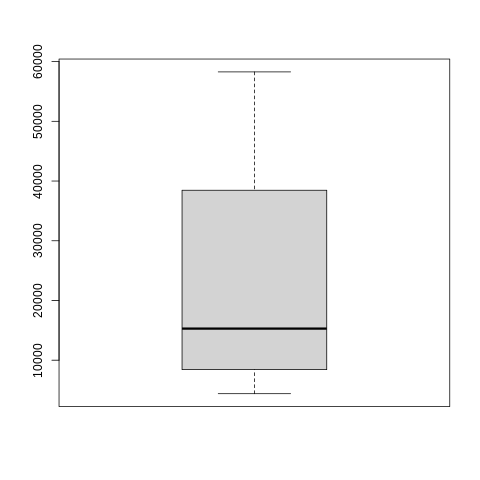

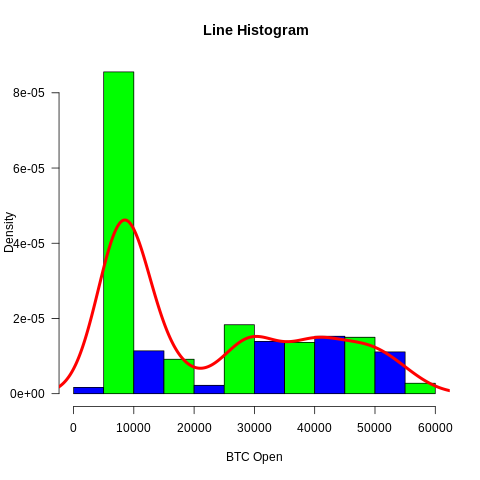

In [ ]:
%%R
boxplot(btc$open)
hist (btc$open, freq = FALSE, col=c ("blue", "green"),
xlab="BTC Open", las =1, main=" Line Histogram")
lines(density(btc$open), lwd = 4, col = "red")

Sur le graphique, on voit que la majoritée des valeurs dans open se trouve en 10.000 et 40.000 et celle avec la plus grande valeurs sont autour de **5000**,**10000**.



# **Variance**

Variance On voit que la variance de Open est enorme, ce qui veut dire que nos valeurs dans open sont très dispersé si la variance était faible on aurait interpreté que nos valeurs n'était pas assez dispersée.

In [ ]:
%%R
var(btc$open)

[1] 268223290


#Ecart type
Elle mesure la dispersion des valeurs de notre echantillon autour de la moyenne. On a un ecart type assez grand aussi 16377.52 donc comme l'ecart est grand alors on interpretera que nos données sont dispersé autour de la moyenne qui est 23032.77  

In [ ]:
%%R
sd(btc$open)


[1] 16377.52


#Tableau des effectifs

In [ ]:
%%R
dataset2 <- read.csv('Kraken_BTCEUR_tradeprints.csv')
globaldata <- read.csv('Kraken_global_data.csv')

cat(colnames(dataset2))
current2 <- data.frame(dataset2$price, dataset2$buysell)
#reduicing features and data size
current <- dataset2[1:20,2:4,1:20] 
prop.table(current)
effOpen1 <- table(globaldata$dollaramount[1:50])
#eff

price volume time buysell ordtype date dollaramount

R[write to console]: Error in FUN(X[[i]], ...) : 
  only defined on a data frame with all numeric-alike variables

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In if (drop) { :
R[write to console]: 
 
R[write to console]:  the condition has length > 1 and only the first element will be used




Error in FUN(X[[i]], ...) : 
  only defined on a data frame with all numeric-alike variables


RInterpreterError: ignored

# Tableau d’effectifs, de contingence, proportions


## Tableau d'effectifs

In [ ]:
%%R
library(caret)
#preObj <- as.data.frame(scale(Kraken_global))
head(btc,10)
#newData <- predict(preObj, Kraken_global)
#summary(newData)
#c <- table(btc)
#prop.table(table(btc$tradecount))
#cat(c)
#plot(table(btc$tradecount),type="h", col=c ("blue"),lwd=2,xlab="tradecount",ylab="Effectif")

R[write to console]: Loading required package: lattice



     price     volume       time buysell ordtype                          date
1  51069.9 0.02349862 1637573490    sell  market 2021-11-22 09:31:30.000400066
2  51070.0 0.04834079 1637573492     buy  market 2021-11-22 09:31:31.547600031
3  51069.9 0.00039750 1637573492    sell   limit 2021-11-22 09:31:32.089900017
4  51069.9 0.00056090 1637573495    sell  market 2021-11-22 09:31:35.442899942
5  51070.0 0.00068355 1637573497     buy  market 2021-11-22 09:31:36.784499884
6  51070.0 0.00036407 1637573498     buy  market 2021-11-22 09:31:37.878200054
7  51069.9 0.00143910 1637573504    sell  market 2021-11-22 09:31:43.689500093
8  51069.9 0.05729206 1637573504    sell  market 2021-11-22 09:31:43.691200018
9  51069.9 0.00060000 1637573504    sell  market 2021-11-22 09:31:43.692199945
10 51069.9 0.00037615 1637573504    sell  market 2021-11-22 09:31:43.693599939
   dollaramount
1    1200.07217
2    2468.76415
3      20.30029
4      28.64511
5      34.90890
6      18.59305
7      73.49469
8  

In [ ]:
%%R
chisq.test(btc$low, btc$tradecount)



	Pearson's Chi-squared test

data:  btc$low and btc$tradecount
X-squared = 500400, df = 499749, p-value = 0.2573



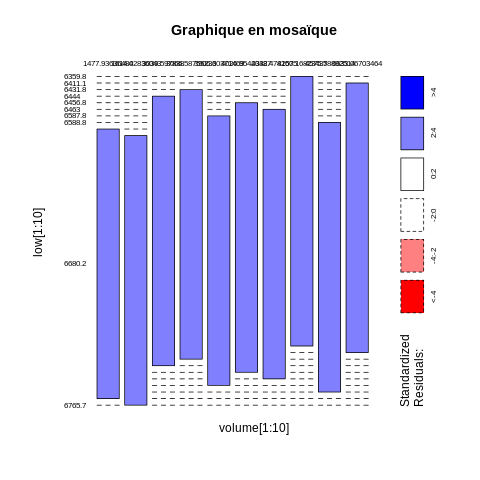

In [138]:
%%R 
mosaicplot(volume[1:10]  ~ low[1:10], data = btc, shade = TRUE,main ="Graphique en mosaïque", las=1)



	Shapiro-Wilk normality test

data:  btc$volume
W = 0.76727, p-value < 2.2e-16



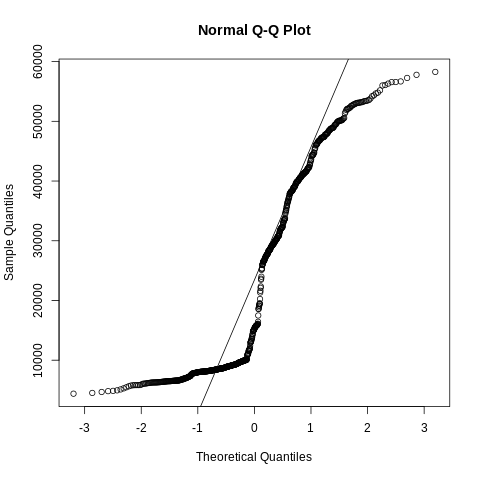

In [ ]:
%%R
qqnorm(btc$open) ; qqline(btc$open)


#Test statistique : Shapiro (Test de normalité)

In [ ]:
%%R
shapiro.test(btc$open)


[1] 0.9977517


#Corelations

In [ ]:
%%R
cor(btc$volume, btc$high)

[1] -0.2277402


#Plots

In [ ]:
%%R
library(plotly)
d <- list(line = list(color = '#d1242c'))
i <- list(line = list(color = '#28a315'))

btc<- data.frame(Kraken_BTCEUR_day)
btc$date <- as.Date(btc$date)
fig <- btc %>% plot_ly(x = ~btc$date, type="candlestick",
                       open = ~btc$open, close = ~btc$close,
                       high = ~btc$high, low = ~btc$low,
                       increasing = i, decreasing = d)
fig <- fig %>% layout(title = 'Prix du Bitcoin en fonction du temps',
                      yaxis = list(title = 'Prix ($)'))
fig


R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: 
    ‘tseries’ version: 0.10-49

    ‘tseries’ is a package for time series analysis and computational
    finance.

    See ‘library(help="tseries")’ for details.




#Test de stationarité de la features Open

Notre serie n'est pas stationnaire car le p-value est superieur à 0.05
ce qui est totalement previsible car le bitcoin est très volatile.

In [ ]:
%%R
library(tseries)
adf.test(btc$open, alternative='stationary')



	Augmented Dickey-Fuller Test

data:  btc$open
Dickey-Fuller = -1.9219, Lag order = 8, p-value = 0.6114
alternative hypothesis: stationary



R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘inline’, ‘loo’, ‘V8’, ‘dygraphs’, ‘extraDistr’, ‘RcppParallel’, ‘rstan’, ‘rstantools’, ‘StanHeaders’, ‘BH’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/inline_0.3.19.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 25074 bytes (24 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri


Error in library("prophet") : there is no package called ‘prophet’


RInterpreterError: ignored

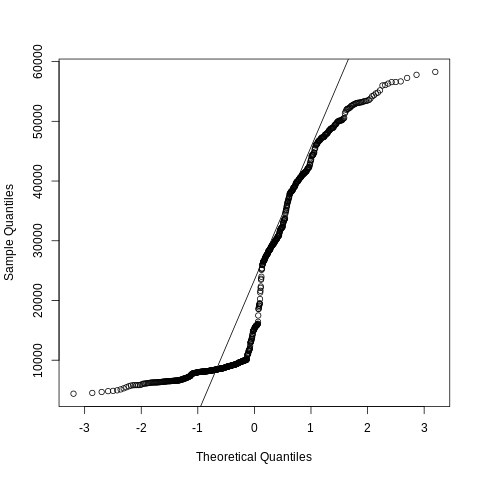

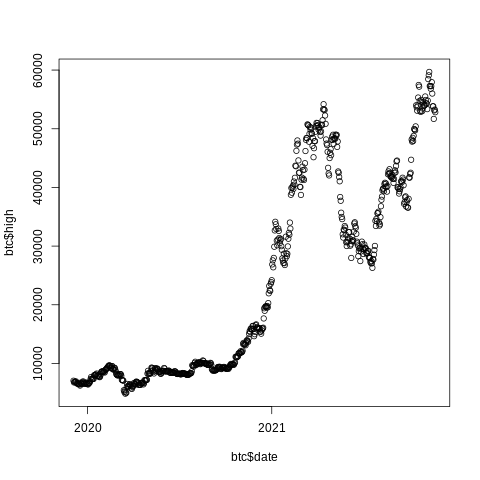

In [ ]:
%%R
library(ggplot2)

qqnorm(kraken$open, main = "");qqline(kraken$open)
ggplot(kraken)
plot(btc$high~btc$date)
#head(global_data, 10)

In [ ]:
%%R
library(plotly)

R[write to console]: 
Attaching package: ‘plotly’


R[write to console]: The following object is masked from ‘package:ggplot2’:

    last_plot


R[write to console]: The following object is masked from ‘package:httr’:

    config


R[write to console]: The following object is masked from ‘package:stats’:

    filter


R[write to console]: The following object is masked from ‘package:graphics’:

    layout




# Machine learning 


Prediction grâce à la regression lineaire


2030.978 2044.214 2041.74 2045.018 2045.451 2045.76 
4598.919

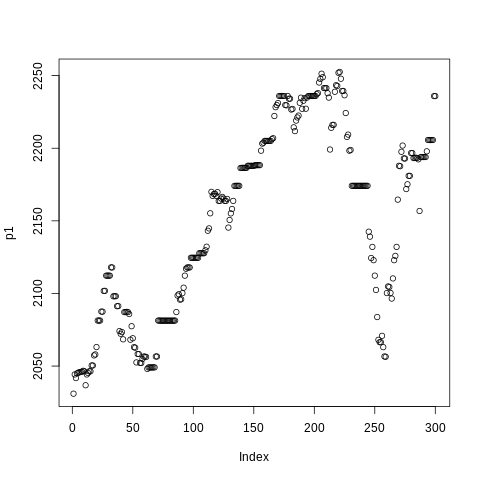

In [ ]:
%%R
btc1 <- read.csv('Kraken_BTCEUR_tradeprints.csv')
mod<-lm(price~dollaramount, data=btc1)
summary(mod)
set.seed(1)
train.index<-sample(1:nrow(btc1),0.70*nrow(btc1), replace=FALSE)
train <- btc1[train.index, ]
test  <- btc1[-train.index,]
#install.packages("AppliedPredictiveModeling")
model1 <- lm(dollaramount~price , train)
summary(model1)
p1 <- predict(model1,test)
cat(head(p1),"\n")
error1 <- p1 - test[["dollaramount"]]
#RMSE
cat(sqrt(mean(error1^2)))
plot(p1)


Model 2

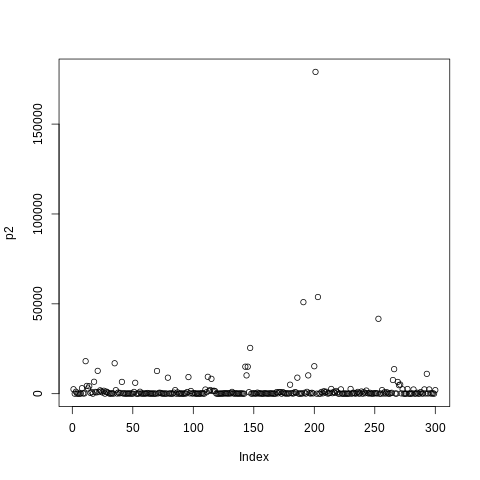

In [ ]:
%%R
model2 <- lm(dollaramo~volume, train)
summary(model2)
p2 <- predict(model2,test)
head(p2)
error2 <- p2 - test[["volume"]]
sqrt(mean(error2^2))
plot(p2)

##Features Extraction

In [ ]:
%%R
library('FactoMineR')
pca_on_global <- read.csv('Kraken_global_data.csv')

pca_on_global1 <- data.frame(pca_on_global)
pca_on_global$date <- NULL
pca_on_global$unix.1 <- NULL
pca_on_global$date.1 <- NULL
pca_on_global$date.2 <- NULL
pca_on_global$buysell <- NULL
pca_on_global$ordtype <- NULL

library(FactoMineR)
pc1<-PCA(pca_on_global,scale.unit = TRUE, ncp = 23, graph = TRUE)
summary(pc1)
a<-dimdesc(pc1,axes = c(1:2))
a$Dim.1
a$Dim.2
stripchart(pca_on_global)

R[write to console]: dev.new(): using pdf(file="Rplots1.pdf")




Call:
PCA(X = pca_on_global, scale.unit = TRUE, ncp = 23, graph = TRUE) 


Eigenvalues
                       Dim.1   Dim.2   Dim.3   Dim.4   Dim.5   Dim.6   Dim.7
Variance               5.798   4.032   2.258   1.935   0.881   0.733   0.254
% of var.             36.237  25.202  14.113  12.093   5.508   4.579   1.588
Cumulative % of var.  36.237  61.439  75.552  87.645  93.154  97.733  99.320
                       Dim.8   Dim.9  Dim.10  Dim.11  Dim.12  Dim.13  Dim.14
Variance               0.059   0.028   0.010   0.006   0.003   0.002   0.001
% of var.              0.368   0.176   0.064   0.038   0.019   0.009   0.005
Cumulative % of var.  99.688  99.864  99.928  99.966  99.985  99.995 100.000
                      Dim.15  Dim.16
Variance               0.000   0.000
% of var.              0.000   0.000
Cumulative % of var. 100.000 100.000

Individuals (the 10 first)
                 Dist    Dim.1    ctr   cos2    Dim.2    ctr   cos2    Dim.3
1            |  3.527 | -2.465  0.516  0.48

In [ ]:
%%R
pc<-prcomp(pca_on_global[,c("low","price")], center = T, scale=T)
summary(pc)
head(pc$x)

           PC1       PC2
[1,] 0.5498544 -1.599305
[2,] 0.5770306 -1.572129
[3,] 0.6549317 -1.494228
[4,] 0.7589187 -1.386633
[5,] 0.7098787 -1.439281
[6,] 0.6537225 -1.491829


In [ ]:
%%R
model3<-lm(low~price, data=pca_on_global)
summary(model3)
p3 <- predict(model3,test)
error3 <- p3 - test[["volume"]]
sqrt(mean(error3^2))
#RMSE=8081.496

[1] 6284.212


intercept is -1.16, which means that when total number of transactions is 0, the average USD market price across major bitcoin exchanges is predicted to be -1.
slope is  9.8,  it tells us that we predict the average USD market price across major bitcoin exchanges to increase by 9.8$ for every additional dollar increase in total number of transactions.

In [ ]:
%%R
options(warn=-1)
d <- list(line = list(color = '#d1242c'))
i <- list(line = list(color = '#28a315'))

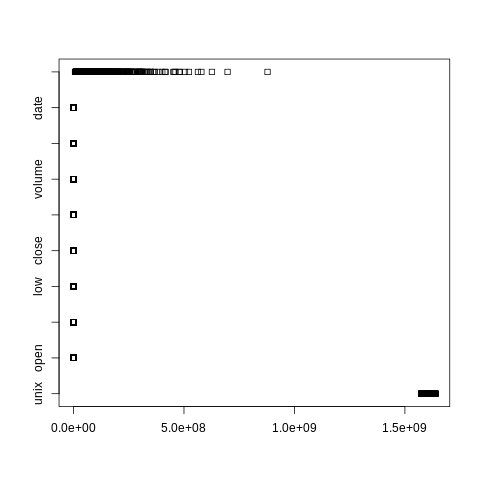

In [ ]:
%%R
btc<- data.frame(Kraken_BTCEUR_day)
btc$date <- as.Date(btc$date)


In [ ]:
%%R
fig <- btc %>% plot_ly(x = ~btc$date, type="candlestick",
                       open = ~btc$open, close = ~btc$close,
                       high = ~btc$high, low = ~btc$low,
                       increasing = i, decreasing = d)
fig <- fig %>% layout(title = 'Prix du Bitcoin en fonction du temps',
                      yaxis = list(title = 'Prix ($)'))

In [ ]:
%%R
fig

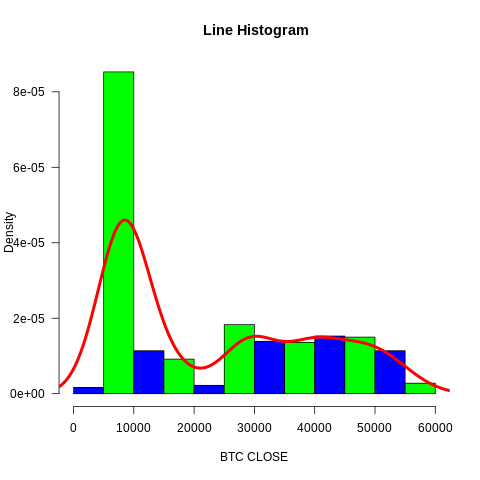

In [ ]:
%%R
hist (btc$close, freq = FALSE, col=c ("blue", "green"),
xlab="BTC CLOSE", las =1, main=" Line Histogram")
lines(density(btc$close), lwd = 4, col = "red")


Descente de gradient avec LM

In [ ]:
%%R
bitcoin  <- data.frame(close=btc$close, open=log(btc$open+1), high=log(btc$high), low=log(btc$low+1), market=log(btc$volume+1))
fit <- step(lm(close ~ open  + high + low + market, data=bitcoin))

Start:  AIC=11792.02
close ~ open + high + low + market

         Df Sum of Sq        RSS   AIC
<none>                9206407087 11792
- low     1  26598012 9233005099 11792
- open    1  49948807 9256355895 11794
- market  1 215624986 9422032073 11807
- high    1 233243710 9439650797 11808


In [ ]:
%%R
colnames(global_data)

 [1] "unix"         "open"         "high"         "low"          "close"       
 [6] "vwap"         "volume"       "tradecount"   "date"         "volume_from" 
[11] "unix.1"       "bid"          "ask"          "date.1"       "spread"      
[16] "price"        "volume.1"     "time"         "buysell"      "ordtype"     
[21] "date.2"       "dollaramount"


In [ ]:
%%R
head(bitcoin, 10)
fit


Call:
lm(formula = close ~ open + high + low + market, data = bitcoin)

Coefficients:
(Intercept)         open         high          low       market  
    -164926       -10978        24525         6717        -1221  



In [ ]:
%%R
bitcoin  <- data.frame(close=btc$close,
                         open=log(btc$open+1),
                         high=log(btc$high),
                         low=log(btc$low+1),
                         market=log(btc$volume+1))
fit <- step(lm(close ~ open  + high 
               + low + market, data=bitcoin))

Start:  AIC=11792.02
close ~ open + high + low + market

         Df Sum of Sq        RSS   AIC
<none>                9206407087 11792
- low     1  26598012 9233005099 11792
- open    1  49948807 9256355895 11794
- market  1 215624986 9422032073 11807
- high    1 233243710 9439650797 11808


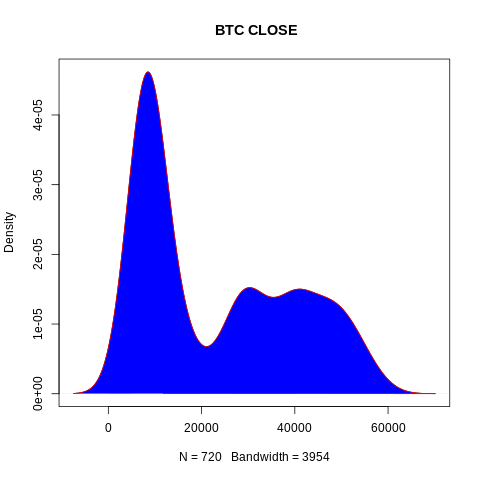

In [ ]:
%%R
library(ggplot2)
d <- density (btc$open)
plot (d, main=" BTC CLOSE")
polygon (d, col="blue", border="red")

[Open]  -->  Moyenne:  23032.77  ;  Mediane:  15289.3 ;  Variance:  268223290 ;  Ecart type:  16377.52 
[Close] -->  Moyenne:  23094.21  ;  Mediane:  15395.15  ;  Variance:  268916598 ;  Ecart type:  16398.68 
[High]  -->  Moyenne:  23696.7  ;  Mediane:  15787.8  ;  Variance:  283309986 ;  Ecart type:  16831.81 
[Low]   -->  Moyenne:  22313.11  ;  Mediane:  14830.3  ;  Variance:  251720587 ;  Ecart type:  15865.7 
Global data frame frame :  unix open high low close vwap volume tradecount date volume_from unix.1 bid ask date.1 spread price volume.1 time buysell ordtype date.2 dollaramount

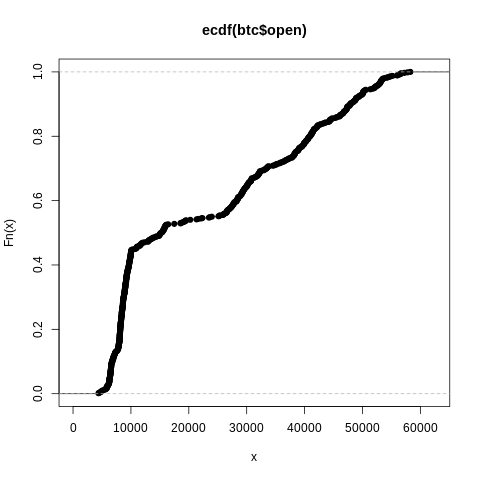

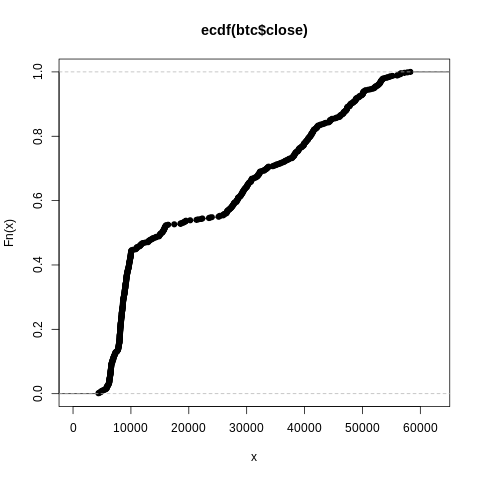

In [ ]:
%%R
btc2 <- data.frame(global_data)
x <- "Moyenne: "
y <- "Mediane: "
z <- "Variance: "
t <- "Ecart type: "
cat ("[Open]  --> ",x,mean(btc$open)," ; ", y, median(btc$open), "; ", z,var(btc$open) ,"; ",t, sd(btc$open),  "\n")
cat ("[Close] --> ",x,mean(btc$close)," ; ", y, median(btc$close), " ; ", z,var(btc$close) ,"; ",t, sd(btc$close),  "\n" )
cat ("[High]  --> ", x,mean(btc$high)," ; ", y, median(btc$high), " ; ", z,var(btc$high) ,"; ",t, sd(btc$high), "\n" )
cat ("[Low]   --> ", x,mean(btc$low)," ; ", y, median(btc$low), " ; ", z,var(btc$low) ,"; ",t, sd(btc$low), "\n" )
cat("Global data frame frame : ",colnames(btc2))
plot(ecdf(btc$open))
plot(ecdf(btc$close))

In [ ]:
%%R
x <- "Moyenne: "
y <- "Mediane: "
z <- "Variance: "
t <- "Ecart type: "
cat ("[Open]  --> ",x,mean(btc$open)," ; ", y, median(btc$open), "; ", z,var(btc$open) ,"; ",t, sd(btc$open),  "\n")
cat ("[Close] --> ",x,mean(btc$close)," ; ", y, median(btc$close), " ; ", z,var(btc$close) ,"; ",t, sd(btc$close),  "\n" )
cat ("[High]  --> ", x,mean(btc$high)," ; ", y, median(btc$high), " ; ", z,var(btc$high) ,"; ",t, sd(btc$high), "\n" )
cat ("[Low]   --> ", x,mean(btc$low)," ; ", y, median(btc$low), " ; ", z,var(btc$low) ,"; ",t, sd(btc$low), "\n" )

[Open]  -->  Moyenne:  23032.77  ;  Mediane:  15289.3 ;  Variance:  268223290 ;  Ecart type:  16377.52 
[Close] -->  Moyenne:  23094.21  ;  Mediane:  15395.15  ;  Variance:  268916598 ;  Ecart type:  16398.68 
[High]  -->  Moyenne:  23696.7  ;  Mediane:  15787.8  ;  Variance:  283309986 ;  Ecart type:  16831.81 
[Low]   -->  Moyenne:  22313.11  ;  Mediane:  14830.3  ;  Variance:  251720587 ;  Ecart type:  15865.7 


In [ ]:
%%R
#table(btc$open)
prop.table(table(btc[10,1:5,10]))*100
tableau <- xtabs(~open +close, data=btc)
tableau
margin.table(tableau, 1)
prop.table(tableau, 1) *100
# Effectif total
margin.table(tableau)

         btc$close
btc$open  4392.8 4519.5 4683.9 4817.7 4867 4953 5113.4 5284.4 5465.8 5629.9
  4392.7       0      0      0      0    0    0      1      0      0      0
  4519.5       0      0      0      0    1    0      0      0      0      0
  4679.2       0      0      0      1    0    0      0      0      0      0
  4817.7       0      1      0      0    0    0      0      0      0      0
  4866.4       0      0      0      0    0    1      0      0      0      0
  4952.6       0      0      0      0    0    0      0      0      0      0
  5106.5       0      0      1      0    0    0      0      0      0      0
  5283.8       0      0      0      0    0    0      0      0      0      0
  5460.1       0      0      0      0    0    0      0      0      0      0
  5629.9       0      0      0      0    0    0      0      1      0      0
  5748.7       0      0      0      0    0    0      0      0      0      1
  5804.6       0      0      0      0    0    0      0      0      0 

From cffi callback <function _consolewrite_ex at 0x7ff336151050>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 135, in _consolewrite_ex
    consolewrite_print(s)
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 118, in consolewrite_print
    print(s, end='', flush=True)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/iostream.py", line 349, in flush
    if not evt.wait(self.flush_timeout):
  File "/usr/lib/python3.7/threading.py", line 552, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.7/threading.py", line 300, in wait
    gotit = waiter.acquire(True, timeout)
KeyboardInterrupt


    0      0      0    0      0      0      0      0    0
  7211.8       1    0      0      0    0      0      0      0      0    0
  7248.3       0    0      0      0    0      0      0      0      0    0
  7291.9       0    0      0      0    0      0      0      0      0    0
  7316.7       0    0      0      0    0      0      0      0      0    0
  7347.9       0    0      0      0    0      0      0      0      0    0
  7361         0    0      0      0    0      0      0      0      0    0
  7566.3       0    0      0      0    0      0      0      0      1    0
  7595.8       0    0      0      0    1      0      0      0      0    0
  7641.5       0    0      1      0    0      0      0      0      0    0
  7722.7       0    0      0      0    0      0      0      0      0    0
  7739.2       0    0      0      0    0      1      0      0      0    0
  7791.1       0    0      0      0    0      0      0      0      0    0
  7796.7       0    0      0      0    0      0      0

From cffi callback <function _consolewrite_ex at 0x7ff336151050>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 135, in _consolewrite_ex
    consolewrite_print(s)
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 118, in consolewrite_print
    print(s, end='', flush=True)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/iostream.py", line 349, in flush
    if not evt.wait(self.flush_timeout):
  File "/usr/lib/python3.7/threading.py", line 552, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.7/threading.py", line 300, in wait
    gotit = waiter.acquire(True, timeout)
KeyboardInterrupt
From cffi callback <function _consolewrite_ex at 0x7ff336151050>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 135, in _consolewrite_ex
    consolewrite_print(s)
  File "/usr/local/lib/p

      0      0    0      0      0      0      0    0
  8015         0    0      0      0    0      0      0      0      0    0
  8017.5       0    0      0      0    0      0      0      0      0    0
  8022.5       0    0      0      0    0      0      0      0      0    0
  8029.9       0    0      0      0    0      0      0      0      0    0
  8033.3       0    0      0      0    0      0      0      0      0    0
  8045         0    0      0      0    0      0      0      0      0    0
  8048.8       0    0      0      0    0      0      0      0      0    0
  8059         0    0      0      0    0      0      0      0      0    0
  8060.5       0    0      0      0    0      0      0      0      0    0
  8062.1       0    0      0      0    0      0      0      0      0    0
  8063.4       0    0      0      0    0      0      0      0      0    0
  8066.3       0    0      0      0    0      0      0      0      0    0
  8069.2       0    0      0      0    0      0      0     

# **histogrammes, courbe de densité**

In [ ]:
%%R
library(Hmisc)
btc_refact <- btc
btc_refact$unix <- NULL
btc_refact$date <- NULL

hist.data.frame(btc_refact)

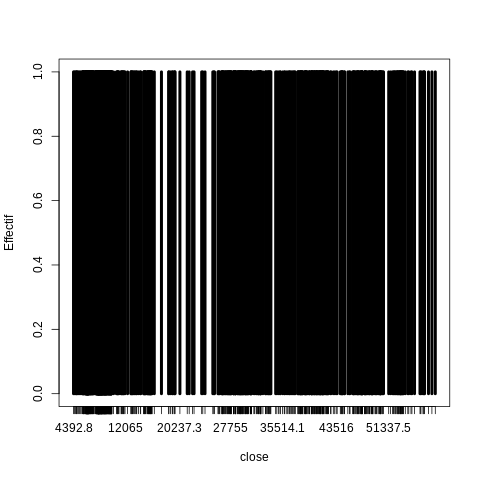

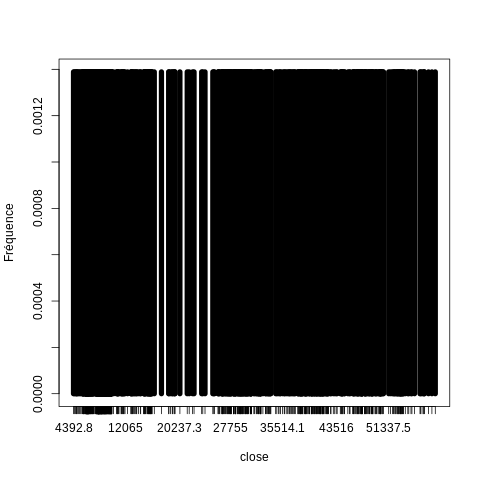

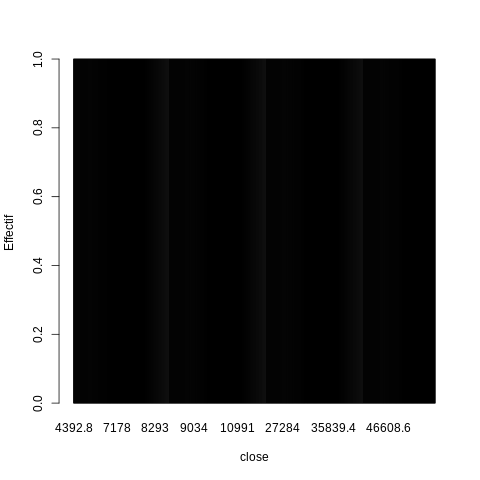

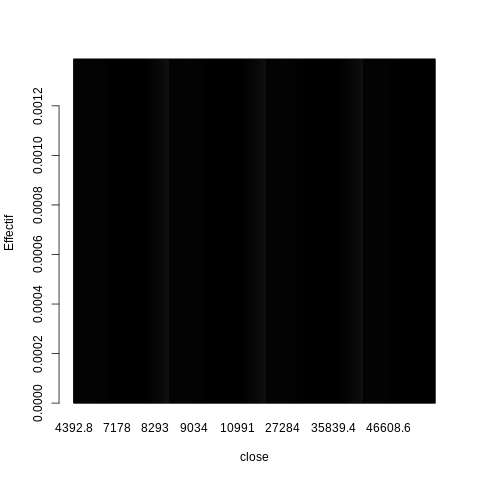

In [ ]:
%%R
table(btc$close)
prop.table(table(btc$close))
plot(table(btc$close),type="h",lwd=4,xlab="close",ylab="Effectif")
plot(prop.table(table(btc$close)),lwd=7,xlab="close",ylab="Fréquence")
barplot(table(btc$close),xlab="close",ylab="Effectif")
barplot(prop.table(table(btc$close)),xlab="close",ylab="Effectif")

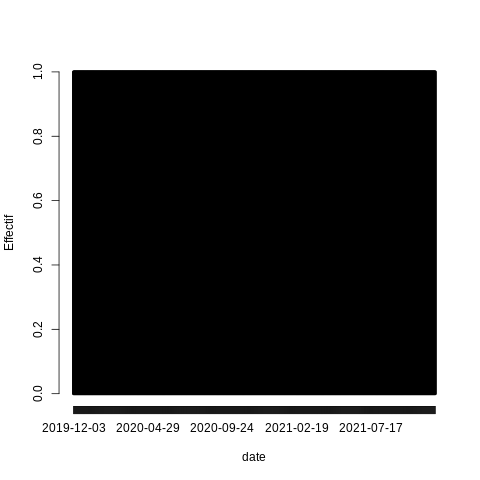

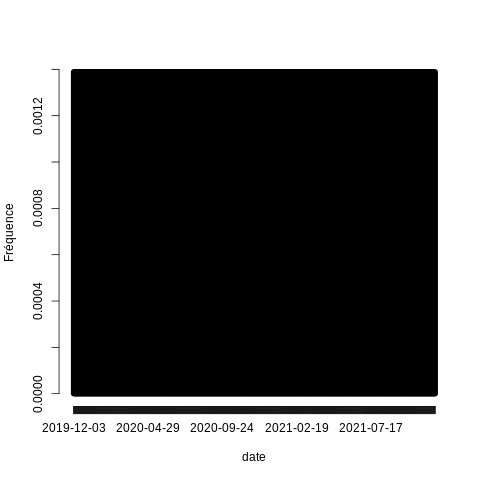

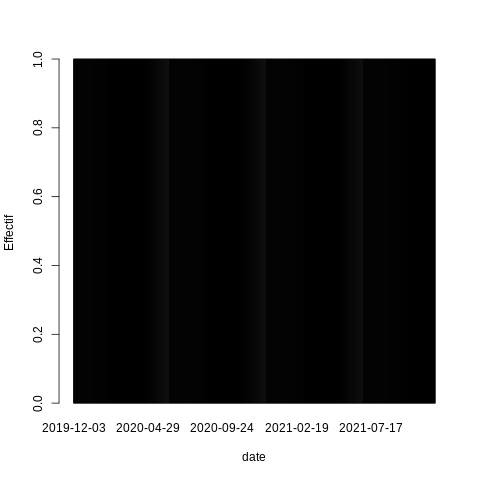

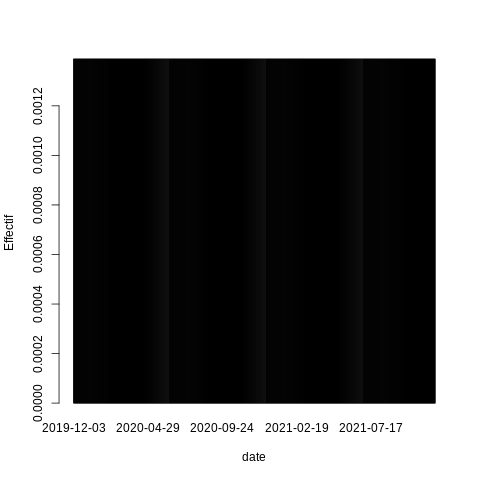

In [ ]:
%%R
table(btc$date)
prop.table(table(btc$date))
plot(table(btc$date),type="h",lwd=4,xlab="date",ylab="Effectif")
plot(prop.table(table(btc$date)),lwd=7,xlab="date",ylab="Fréquence")
barplot(table(btc$date),xlab="date",ylab="Effectif")
barplot(prop.table(table(btc$date)),xlab="date",ylab="Effectif")

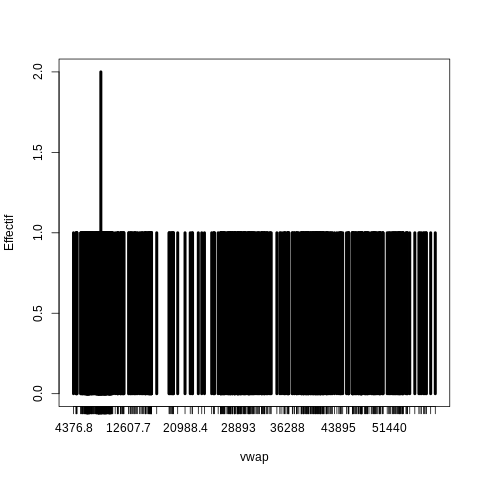

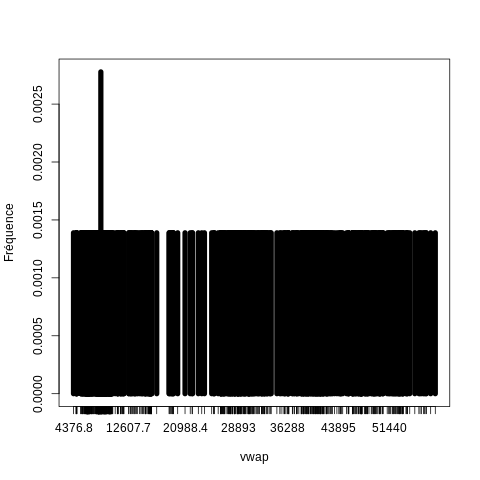

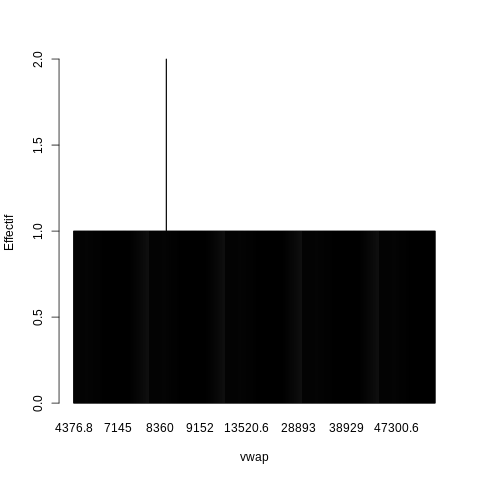

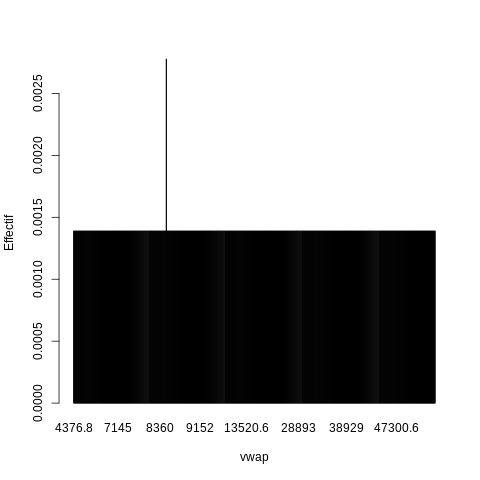

In [ ]:
%%R
table(btc$vwap)
prop.table(table(btc$vwap))
plot(table(btc$vwap),type="h",lwd=4,xlab="vwap",ylab="Effectif")
plot(prop.table(table(btc$vwap)),lwd=7,xlab="vwap",ylab="Fréquence")
barplot(table(btc$vwap),xlab="vwap",ylab="Effectif")
barplot(prop.table(table(btc$vwap)),xlab="vwap",ylab="Effectif")

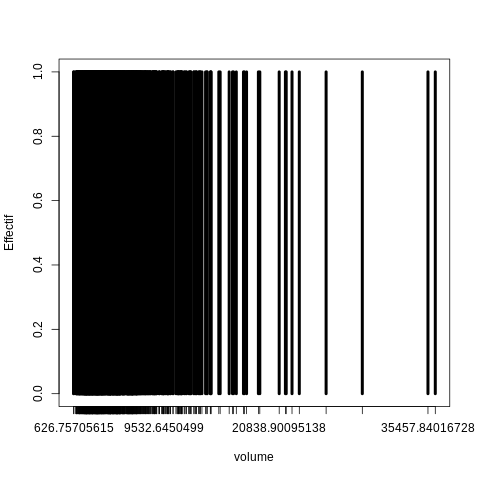

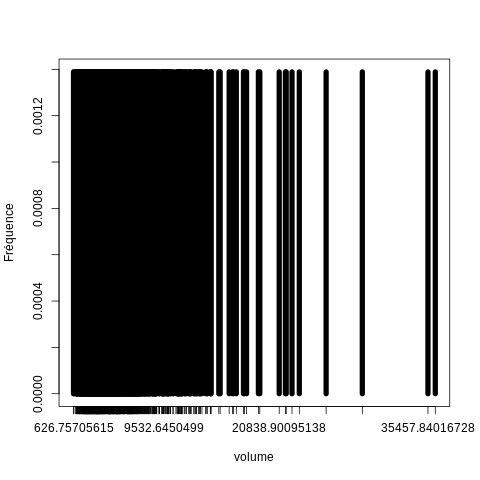

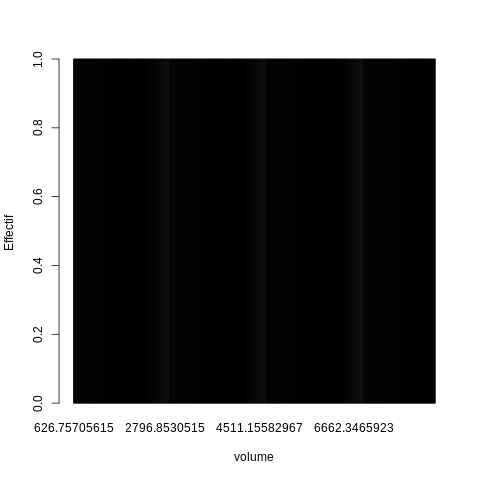

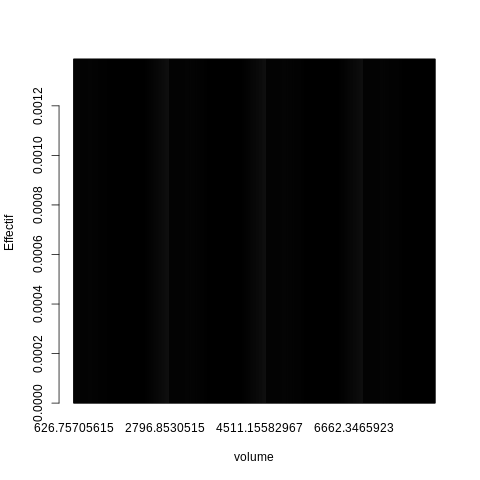

In [ ]:
%%R
table(btc$volume)
prop.table(table(btc$volume))
plot(table(btc$volume),type="h",lwd=4,xlab="volume",ylab="Effectif")
plot(prop.table(table(btc$volume)),lwd=7,xlab="volume",ylab="Fréquence")
barplot(table(btc$volume),xlab="volume",ylab="Effectif")
barplot(prop.table(table(btc$volume)),xlab="volume",ylab="Effectif")

In [ ]:
%%R
effectifs <- table(btc$open, btc$close, deparse.level = 2, useNA = "always")

In [ ]:
%%R
prop.table(effectifs) # fréquences relatives

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  6589.2  0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  6590.7  0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  6595.1  0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  6600.1  0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  6606.6  0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  6611.2  0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  6635.1  0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  6660    0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  6687.9  0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  6689    0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  6778    0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  6786.6  0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  6788    0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  6800.4  0.

In [ ]:
%%R
prop.table(effectifs)* 100 # fréquence absolues (pourcentage)

UsageError: Cell magic `%%R` not found.


Les résultats sont ici très contrastés. Nous avons 57,8%, et 39,9% de personnes qui n’ont pas lu cette année, ou été au cinéma.

Notes : vous pouvez remplacer la fonction table() par xtabs(). L’avantage de cette commande est de ne pas avoir à préfixer le nom des variables par le nom du dataframe.

In [ ]:
%%R
dplyr::tbl_df(btc)

# A tibble: 720 × 10
     unix  open  high   low close  vwap volume tradecount date       volume_from
    <int> <dbl> <dbl> <dbl> <dbl> <dbl>  <dbl>      <int> <date>           <dbl>
 1 1.58e9 6595. 7048. 6411. 6493. 6634.  6633.      25656 2019-12-04   43069831.
 2 1.58e9 6493. 6753. 6457. 6660. 6633.  4027.      18589 2019-12-05   26817502.
 3 1.58e9 6660  6870. 6588. 6828. 6700.  3906.      17236 2019-12-06   26672632.
 4 1.58e9 6828. 6885  6766. 6779. 6809.  1614.      10426 2019-12-07   10940853.
 5 1.58e9 6778  6848  6680. 6804. 6790   1478.      10336 2019-12-08   10055436.
 6 1.58e9 6803. 6932. 6589. 6635  6739   4576.      17537 2019-12-09   30359033.
 7 1.58e9 6635. 6686  6463  6515. 6576.  4038.      17747 2019-12-10   26311897.
 8 1.58e9 6515. 6570. 6444  6478. 6510.  3040.      13768 2019-12-11   19691731.
 9 1.58e9 6480. 6555  6360. 6432. 6448.  4150.      16455 2019-12-12   26693052.
10 1.58e9 6432. 6557. 6432. 6525. 6490.  3067.      12595 2019-12-13   20008870.
# … wit

In [ ]:
%%R
pm <-colnames(global_data)
btc1 <- data.frame(global_data)

for (i in pm){
    print(i)
}

[1] "unix"
[1] "open"
[1] "high"
[1] "low"
[1] "close"
[1] "vwap"
[1] "volume"
[1] "tradecount"
[1] "date"
[1] "volume_from"
[1] "unix.1"
[1] "bid"
[1] "ask"
[1] "date.1"
[1] "spread"
[1] "price"
[1] "volume.1"
[1] "time"
[1] "buysell"
[1] "ordtype"
[1] "date.2"
[1] "dollaramount"


In [ ]:
%%R
library(tidyverse)
install.packages('Hmisc')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘checkmate’, ‘Formula’, ‘latticeExtra’, ‘htmlTable’, ‘viridis’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/checkmate_2.0.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 168716 bytes (164 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


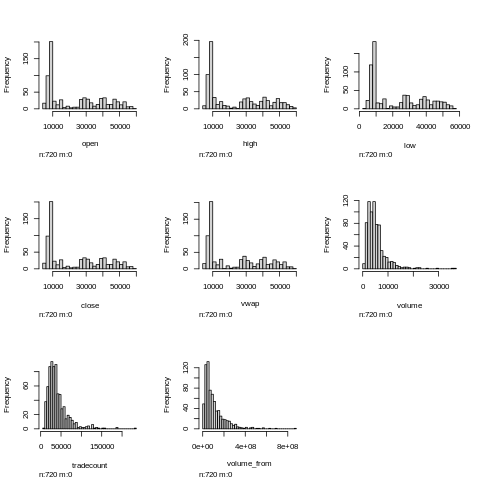

In [ ]:
%%R
library(Hmisc)
btc_refact <- btc
btc_refact$unix <- NULL
btc_refact$date <- NULL

hist.data.frame(btc_refact)

In [ ]:
%%R
#library("anytime")
#library("bsts")
#library("car")
#library("caret")
#library("forecast")
#install.packages('keras')
#install.packages('tensorflow')
install.packages("MCMCpack")
#install.packages('MCMCpack')
install.packages('TTR')
install.packages('tseries')
#library("keras")
#library("MCMCpack")
#library("smooth")
library("tensorflow")
library("tseries")
library("TTR")


trainset <- data.frame(date=btc$date,volume=btc$volume, 
                       close=btc$close, open=log(btc$open+1), 
                       high=log(btc$high),  low=log(btc$low+1),  
                       market.Cap=log(btc$volume+1))
testset <- data.frame(date=btc$date, close=btc$close)
#Converting data for analysis
train$date <- as.Date(anytime(train$Date))
test$date <- as.Date(anytime(test$Date))
train$volume <- gsub(",", "", train$Volume)
train$market.Cap <- gsub(",", "", train$Market.Cap)
train$Market.Cap <- as.numeric(train$Market.Cap)
train$volume <- as.numeric(train$Volume)
#Difference between high and low on each day
a <- matrix(c(0), nrow = 0, ncol = 1)
for(i in 1:nrow(train)){
  a <- rbind(a, train[i,3] - train[i,4])
  i <- i + 1
}
train <- cbind(train,a)
+9900

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/MCMCpack_1.6-0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1030765 bytes (1006 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w


Error in anytime(train$Date) : could not find function "anytime"


RInterpreterError: ignored

R[write to console]: Error in hist.data.frame(num_data) : object 'num_data' not found




Error in hist.data.frame(num_data) : object 'num_data' not found


RInterpreterError: ignored

# Bitcoin price prediction avec la librairy Prophet

In [ ]:
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
install.packages("prophet")
#.libPaths('prophet')
library(prophet)
btc_row <- read.csv('Kraken_BTCEUR_tradeprints.csv')
data_1 <- data.frame(date=btc_row$date, y=btc_row$price)
head(data_1, 10)
model1 <- prophet(data_1)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘V8’, ‘rstan’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/V8_3.6.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 794523 bytes (775 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to


Error in library(prophet) : there is no package called ‘prophet’


RInterpreterError: ignored